In [4]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


In configuration space the centroid uncertainty could be a problem

If I shift the galaxy, then rotate the galaxy refering to the new center with shifted offset. Finally, shear the galaxy refering to the new center. It is not a problem.

Otherwite it has bias.

In [5]:
cd wrkDir/FPFS2/sim

/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


In [8]:
# PSF preparation
ifield=1
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   4
nx          =   nrot 
ny          =   1
ndata       =   nx*ny
scale       =   0.16
ngridTot    =   ngrid*nx
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
noiseHead   =   pyfits.getheader(psfFname)
if False:
    psfImg      =   galsim.fits.read(psfFname)
    psfImg.setOrigin(0,0)
    psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
else:
    psfInt      =   galsim.Gaussian(fwhm=0.65,flux=1.)
    psfImg      =   galsim.ImageF(ngrid,ngrid,scale=scale)
    psfImg.setOrigin(0,0)
    psfInt.drawImage(psfImg,offset=(0.5,0.5),method='no_pixel')

# Get the shear information
g1          =   0.02#noiseHead['g1']
g2          =   0.#noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)
print(psfImg.FindAdaptiveMom())

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((7.460516645161128e-17-5.928941117565709e-18j)), moments_sigma=1.7251849174499512, moments_amp=1.0, moments_centroid=galsim.PositionD(x=32.0, y=32.0), moments_rho4=1.999999987103873, moments_n_iter=12, correction_status=-10)


In [26]:
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
var_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
var_image.setOrigin(0,0)
data_rows   =   []

# Get the  galaxy generator      
# Load data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   '/home/xiangchong/work/gw_ipmu/work/galsim_train/COSMOS_25.2_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)
# index
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
index       =   ifield%81400
record      =   param_cat[index]
# prepare the galaxies
if True:
    gal0    =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
else:
    gal0    =   galsim.Gaussian(fwhm=1.2,flux=2.)
    
gal0        *=  flux_scaling
gal0=gal0.shift(0.1,-0.14)
for i in range(nrot):
    # Prepare the subimage
    ix      =   int(i%nx)
    iy      =   int(i/nx)
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    if i%nrot==0:
        gal     =   gal0
    else:
        gal     =   gal.rotate(1./nrot*np.pi*galsim.radians)
    final   =   gal.shear(g1=g1,g2=g2)
    # Shear the galaxy
    final     =   galsim.Convolve([psfInt,final],gsparams=bigfft)
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel',offset=(0.5,0.5))
    print(sub_gal_image.FindAdaptiveMom())

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((0.018069152998259955-0.11513204305170723j)), moments_sigma=1.982532024383545, moments_amp=6.640722274780273, moments_centroid=galsim.PositionD(x=32.6376281834525, y=31.142328437010143), moments_rho4=2.055033477988338, moments_n_iter=20, correction_status=-10)
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=64, xmax=127, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((0.11859660100700527+0.012833033831924107j)), moments_sigma=1.9865751266479492, moments_amp=6.633607387542725, moments_centroid=galsim.PositionD(x=97.0820902064078, y=31.82672416297054), moments_rho4=2.0560617976217346, moments_n_iter=19, correction_status=-10)
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=128, xmax=191, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((-0.008008621690627932+0.11554951924287349j)), moments_sigma=1.9814916849136353, m

In [36]:
class fpfsBaseTask():
    _DefaultName = "fpfsBase"
    def __init__(self,psfData):
        self.ngrid   =   psfData.shape[0]
        self.psfPow  =   self.getPow(psfData)
        # Get PSF power and radius
        self.beta    =   0.2
        self.sigma   =   self.getHLRnaive(self.psfPow,self.beta)
        self.prepareRlim()
        self.chi     =   self.shapeletsPrepare(4)
        return
    
    def getHLRnaive(self,imgData,beta):
        imgData2=   np.abs(imgData)
        # Get the half light radius of noiseless PSF
        thres   =   imgData2.max()*0.5
        sigma   =   np.sum(imgData2>thres)
        sigma   =   np.sqrt(sigma/np.pi)*beta
        sigma   =   max(1.,min(sigma,4.))
        return sigma
    
    def prepareRlim(self):
        # Get rlim
        thres   =   1.e-3
        for dist in range(12,30):
            ave =  abs(np.exp(-dist**2./2./self.sigma**2.)/self.psfPow[ngrid//2+dist,ngrid//2])
            ave +=  abs(np.exp(-dist**2./2./self.sigma**2.)/self.psfPow[ngrid//2,ngrid//2+dist])
            ave =   ave/2.
            if ave<=thres:
                self.rlim=   dist
                break
        self.indX=np.arange(self.ngrid//2-self.rlim,self.ngrid//2+self.rlim+1)
        self.indY=self.indX[:,None]
        self.ind2D=np.ix_(self.indX,self.indX)
        return
    
    def shapeletsPrepare(self,nord):
        # Prepare the shapelets function
        ngrid   =   self.ngrid
        mord    =   nord
        # Set up the r and theta function
        xy1d    =   np.fft.fftshift(np.fft.fftfreq(ngrid,d=self.sigma/ngrid))
        xfunc,yfunc=  np.meshgrid(xy1d,xy1d)
        rfunc   =   np.sqrt(xfunc**2.+yfunc**2.)
        gaufunc =   np.exp(-rfunc*rfunc/2.)
        rmask   =   (rfunc!=0.)
        xtfunc  =   np.zeros((ngrid,ngrid),dtype=np.float64)  
        ytfunc  =   np.zeros((ngrid,ngrid),dtype=np.float64)
        np.divide(xfunc,rfunc,where=rmask,out=xtfunc)
        np.divide(yfunc,rfunc,where=rmask,out=ytfunc)
        eulfunc = xtfunc+1j*ytfunc   
        lfunc   =   np.zeros((nord+1,mord+1,ngrid,ngrid),dtype=np.float64)
        chi     =   np.zeros((nord+1,mord+1,ngrid,ngrid),dtype=np.complex64)
        # Set up l function
        lfunc[0,:,:,:]=1.
        lfunc[1,:,:,:]=1.-rfunc*rfunc+np.arange(mord+1)[None,:,None,None]
        # 
        for n in range(2,nord+1):
            for m in range(mord+1):
                lfunc[n,m,:,:]=(2.+(m-1.-rfunc*rfunc)/n)*lfunc[n-1,m,:,:]-(1.+(m-1.)/n)*lfunc[n-2,m,:,:]
        for nn in range(nord+1):
            for mm in range(nn,-1,-2):
                c1=(nn-abs(mm))//2
                d1=(nn+abs(mm))//2
                cc=np.math.factorial(c1)+0.
                dd=np.math.factorial(d1)+0.
                cc=cc/dd/np.pi
                chi[nn,mm,:,:]=pow(-1.,d1)/self.sigma*pow(cc,0.5)*lfunc[c1,abs(mm),:,:]*pow(rfunc,abs(mm))*gaufunc*eulfunc**mm
        return chi
    
    def getPow(self,galData):
        galData.astype(np.float64)
        galData=np.fft.ifftshift(galData)
        # Get power function and subtract noise power
        galpow  =   np.fft.fft2(galData)#np.abs(np.fft.fft2(galData))**2.
        galpow  =   np.fft.fftshift(galpow)
        return galpow
    
    def deconvolvePow(self,galData,noiData=None):
        # Deconvolve the galaxy power with the PSF power
        
        # Subtract the noiPow
        ngrid   =   galData.shape[0]
        if noiData is not None:
            minPow,noiPow2  =   self.removeNoiPow(ngrid,galData,noiData,self.rlim)
        else:
            minPow=galData;noiPow2=None
        decPow  =   np.zeros(galData.shape,dtype=np.complex64)
        decPow[self.ind2D]=minPow[self.ind2D]/self.psfPow[self.ind2D]
        return decPow,noiPow2,minPow
    
    def removeNoiPow(self,ngrid,galPow,noiPowR,rlim):
        rlim2       =   max(27,rlim)
        noiList     =   []
        valList     =   []
        for j in range(ngrid):
            for i in range(ngrid):
                ii=i-ngrid/2.
                jj=j-ngrid/2.
                r   =   np.sqrt(ii**2.+jj**2.)
                if r>rlim2:
                    valList.append(galPow[j,i])
                    noiList.append(noiPowR[:,j,i])
        vl  =   np.array(valList)
        nl  =   np.array(noiList)
        nl  =   np.hstack([nl,np.ones((nl.shape[0],1))])
        par =   np.linalg.lstsq(nl,vl)[0]
        #self.log.info('%s' %par)
        noiSub   =   np.zeros((ngrid,ngrid))
        npar=   len(par)
        for ipc in range(npar-1):
            noiSub+=(par[ipc]*noiPowR[ipc])
        noiSub  +=  par[-1]
        minPow  =   galPow-noiSub
        return minPow,noiSub
    
    def measMoments(self,data):
        height  =   data.shape[0]
        width   =   data.shape[1]
        print(np.abs(data.imag).max())
        MAll    =   np.sum(data[None,None,self.indY,self.indX]*self.chi[::2,:4:2,self.indY,self.indX],axis=(2,3))
        MC      =   MAll.real
        MS      =   MAll.imag
        types=[('fpfs_M00','>f8'),('fpfs_M20','>f8') ,('fpfs_M22c','>f8'),('fpfs_M22s','>f8'), \
               ('fpfs_M40','>f8'),('fpfs_M42c','>f8'),('fpfs_M42s','>f8')]
        M00 =MC[0,0];M20 =MC[1,0];M40 =MC[2,0]
        M22c=MC[1,1];M22s=MS[1,1]
        M42c=MC[2,1];M42s=MS[2,1]
        return np.array((M00,M20,M22c,M22s,M40,M42c,M42s),dtype=types) 
    
    def measure(self,galData):
        if len(galData.shape)==2:
            return self.measureSingle(galData)
        elif len(galData.shape)==3:
            results=[]
            for gal in galData:
                results.append(self.measureSingle(gal))
            return np.vstack(results)
        else:
            pass
            
    def measureSingle(self,galData):
        galPow  =   self.getPow(galData)
        #get the shapelets file
        decPow,noiPowModel,minPow  =   self.deconvolvePow(galPow)
        return self.measMoments(decPow)

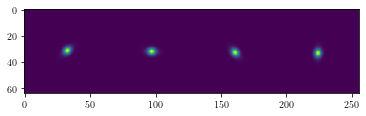

In [37]:
plt.imshow(gal_image.array)
pyfits.writeto('aaa.fits',gal_image.array,overwrite=True)

In [38]:
if False:
    print(psfImg.array.shape)
    psfData=np.pad(psfImg.array,(10,11))
    print(psfData.shape)
    psfImg2=galsim.ImageF(psfData)
else:
    psfData=psfImg.array
    psfImg2=psfImg
print(psfImg.FindAdaptiveMom())
fpTask=fpfsBaseTask(psfData)

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((7.460516645161128e-17-5.928941117565709e-18j)), moments_sigma=1.7251849174499512, moments_amp=1.0, moments_centroid=galsim.PositionD(x=32.0, y=32.0), moments_rho4=1.999999987103873, moments_n_iter=12, correction_status=-10)


In [39]:
fpTask.measure(gal_image.array[:,0*ngrid:1*ngrid])

3.3239896


array((31.99718666, 29.2716713, -0.08341003, 1.73090184, 27.30231857, -0.07362626, 2.41747284),
      dtype=[('fpfs_M00', '>f8'), ('fpfs_M20', '>f8'), ('fpfs_M22c', '>f8'), ('fpfs_M22s', '>f8'), ('fpfs_M40', '>f8'), ('fpfs_M42c', '>f8'), ('fpfs_M42s', '>f8')])

In [40]:
def test_speed():
    for i in range(10000):
        fpTask=fpfsBaseTask(psfData)
        fpTask.measure(gal_image.array[:,0*ngrid:1*ngrid])
    return

In [ ]:
# old code
%time test_speed()

In [139]:
# new code
%time test_speed()

CPU times: user 4.38 s, sys: 3.38 ms, total: 4.39 s
Wall time: 4.39 s


In [27]:
# new code 2
%time test_speed()

CPU times: user 13.1 s, sys: 20.4 ms, total: 13.1 s
Wall time: 13.1 s


In [42]:
print(g1,g2)
mm1=fpTask.measure(gal_image.array[:,0*ngrid:1*ngrid])
mm2=fpTask.measure(gal_image.array[:,1*ngrid:2*ngrid])
mm3=fpTask.measure(gal_image.array[:,2*ngrid:3*ngrid])
mm4=fpTask.measure(gal_image.array[:,3*ngrid:4*ngrid])
print(mm1)
print(mm2)
print(mm3)
print(mm4)

0.02 0.0
3.3239896
3.391271
3.3524604
3.4119742
(31.99718666, 29.2716713, -0.08341003, 1.73090184, 27.30231857, -0.07362626, 2.41747284)
(31.94882965, 29.15210724, -1.79079378, -0.00695374, 27.14342308, -2.49253702, 0.03329651)
(31.99765968, 29.26861382, -0.06692141, -1.73360395, 27.29136658, -0.1360631, -2.42198801)
(32.04669571, 29.38957787, 1.67539728, 0.00970003, 27.45310593, 2.34903955, -0.02881523)


0.0


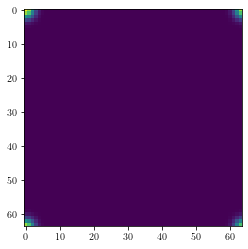

In [43]:
galData= psfImg.array#gal_image.array[:,3*ngrid:4*ngrid]#
galData.astype(np.float64)
galData=np.fft.ifftshift(galData)
imshow(galData)
# Get power function and subtract noise power
galpow  =   np.fft.fft2(galData)#np.abs(np.fft.fft2(galData))**2.
galpow  =   np.fft.fftshift(galpow)
print(np.abs(galpow.imag).max())

In [44]:
def momentsToElli(moments, doCalib=True):
    const   =   1
    #Get weight
    weight  =   moments['fpfs_M20']+const
    #FPFS flux
    flux    =   moments['fpfs_M00']/weight
    #Ellipticity
    e1      =   -moments['fpfs_M22c']/weight
    e2      =   -moments['fpfs_M22s']/weight
    e41     =   -moments['fpfs_M42c']/weight
    e42     =   -moments['fpfs_M42s']/weight
    #Response factor 
    R1      =   1./np.sqrt(2.)*(moments['fpfs_M00']-moments['fpfs_M40'])/weight+np.sqrt(6)*(e1*e41)
    R2      =   1./np.sqrt(2.)*(moments['fpfs_M00']-moments['fpfs_M40'])/weight+np.sqrt(6)*(e2*e42)
    RA      =   (R1+R2)/2.
    ellDat      =   np.array(np.zeros(len(e1)),dtype=[('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RA','>f8'),('fpfs_flux','>f8')])
    ellDat['fpfs_e1']=e1.transpose()
    ellDat['fpfs_e2']=e2.transpose()
    ellDat['fpfs_RA']=RA.transpose()
    ellDat['fpfs_flux']=flux.transpose()
    return ellDat

In [45]:
ee=momentsToElli(np.vstack([mm1,mm2,mm3,mm4]))

In [46]:
print(np.sum(ee['fpfs_e1'])/np.sum(ee['fpfs_RA'])-g1)
print(np.sum(ee['fpfs_e2'])/np.sum(ee['fpfs_RA'])-g2)

-1.1366240203636996e-05
1.4036002155162847e-05


In [ ]:
rng = galsim.BaseDeviate(ifield)
max_variance=   np.max(var_image.array)
var_image   =   max_variance - var_image
vn          =   galsim.VariableGaussianNoise(rng,var_image)
gal_image.addNoise(vn)
corNoise    =   galsim.getCOSMOSNoise(file_name='./corPre/correlation.fits',rng=rng,cosmos_scale=scale,variance=variance)
unCorNoise  =   galsim.UncorrelatedNoise(max_variance,rng=rng,scale=scale)
corNoise    =   corNoise-unCorNoise
corNoise.applyTo(gal_image)
exposure    =   afwImg.ExposureF(nx*ngrid,ny*ngrid)
exposure.getMaskedImage().getImage().getArray()[:,:]=gal_image.array
exposure.getMaskedImage().getVariance().getArray()[:,:]=variance*rescale
del gal_image
del var_image
#Set the PSF
psfArray    =   psfImg.array
ngridPsf    =   psfArray.shape[0]
psfLsst     =   afwImg.ImageF(ngridPsf,ngridPsf)
psfLsst.getArray()[:,:]= psfArray
psfLsst     =   psfLsst.convertD()
kernel      =   afwMath.FixedKernel(psfLsst)
kernelPSF   =   meaAlg.KernelPsf(kernel)
exposure.setPsf(kernelPSF)
#prepare the wcs
#Rotation
cdelt   =   (0.168*afwGeom.arcseconds)
CD      =   afwGeom.makeCdMatrix(cdelt, afwGeom.Angle(0.))#no rotation
#wcs
crval   =   afwCoord.IcrsCoord(0.*afwGeom.degrees, 0.*afwGeom.degrees)
crpix   =   afwGeom.Point2D(0.0, 0.0)
dataWcs =   afwGeom.makeSkyWcs(crpix,crval,CD)
exposure.setWcs(dataWcs)
#prepare the frc
dataCalib = afwImg.Calib()
dataCalib.setFluxMag0(63095734448.0194)
exposure.setCalib(dataCalib)
exposure.writeFits(outFname)
del exposure
t = Table(rows=data_rows, names=('ipos','COSMOS_INDEX','IDENT','RA','DEC','COSMOS_MAG','a_i','parent_seeing'))
catPreName  =   os.path.join(catPre,'catalog-%04d.fits' %(ifield))
t.write(catPreName,overwrite=True)